In [44]:
# Imports, as always...
from math import log
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Script imports.
from dataset import load_dataset, load_flipped_dataset

# Styling.
sns.set_theme(style='darkgrid', palette=palette)

# Ignore warnings.
import warnings

warnings.filterwarnings('ignore')

In [2]:
dataset_path = 'martina/data/walkerDataset/all-dataset-1000.npz'
machines = [
    'ibmq_athens', 'ibmq_casablanca', 'ibmq_lima', 'ibmq_quito', 'ibmq_santiago', 'ibmq_5_yorktown'
]
machine_names = [ms.split('_')[-1].capitalize() for ms in machines]

In [3]:
# This is what Martina et al. (2021) says is the true distribution.
y_true = np.array([.0, .5, .25, .25])

# Data Exploration

Explorationing the data.

## Noise Fingerprints as Element-wise Arithmetic Difference.

One interpretation for the noise fingerprint is the difference each measured outcome has with its anticipated (true) outcome value. This allows us to see broadly 'how much noise' ends up in each dimension of the eventual feature vector in any machine learning we do on these fingerprints, though it may miss out the interactivity between qubits. 

In [41]:
# Load in the all data (numpy).
xs, _, _, ys, _, _ = load_dataset(dataset_path, steps=[2], test_size=.0, val_size=.0, as_torch=False)

# Getting only the noise (i.e. the difference from the true distribution).
xs_noise = xs - y_true

In [5]:
# Statistics on ALL noise data.
pd.DataFrame(xs_noise).describe()

,0,1,2,3
count,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.118963,-0.082144,-0.019811,-0.017008
std,0.048560,0.049427,0.044667,0.040855
min,0.033000,-0.285000,-0.140000,-0.115000
25%,0.074000,-0.127000,-0.042000,-0.044000
50%,0.111000,-0.069000,-0.017000,-0.021000
75%,0.158000,-0.042000,0.012000,0.001000
max,0.278000,0.040000,0.123000,0.225000


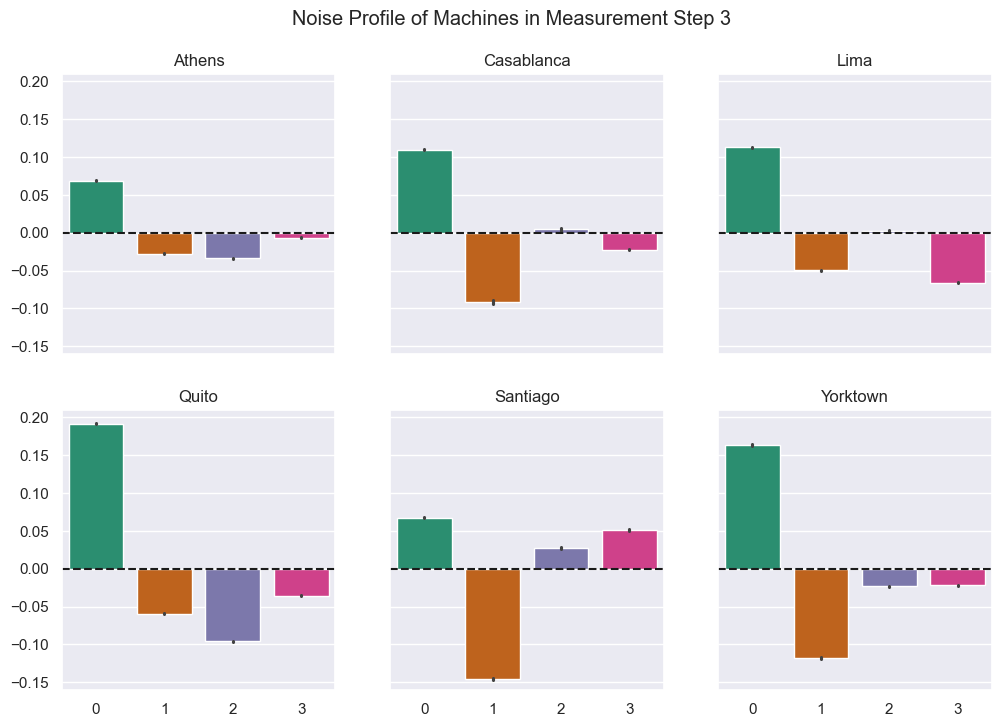

In [42]:
# For each machine over all measurement steps.
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex='col', sharey='row')

for i, ax in enumerate(axes.flatten()):
    # Plot
    sns.barplot(xs_noise[ys == i], ax=ax, palette='Dark2')
    ax.axhline(0, color='k', linestyle='--')
    
    # Common scaling.
    ax.set_ylim(-.16, .21)
    
    # Titles.
    ax.set_title(machine_names[i])
    
# Beautification.
fig.suptitle('Noise Profile of Machines in Measurement Step 3', y=.96)

plt.savefig('./figures/martina-machines-noise-step-3.pdf', bbox_inches='tight')

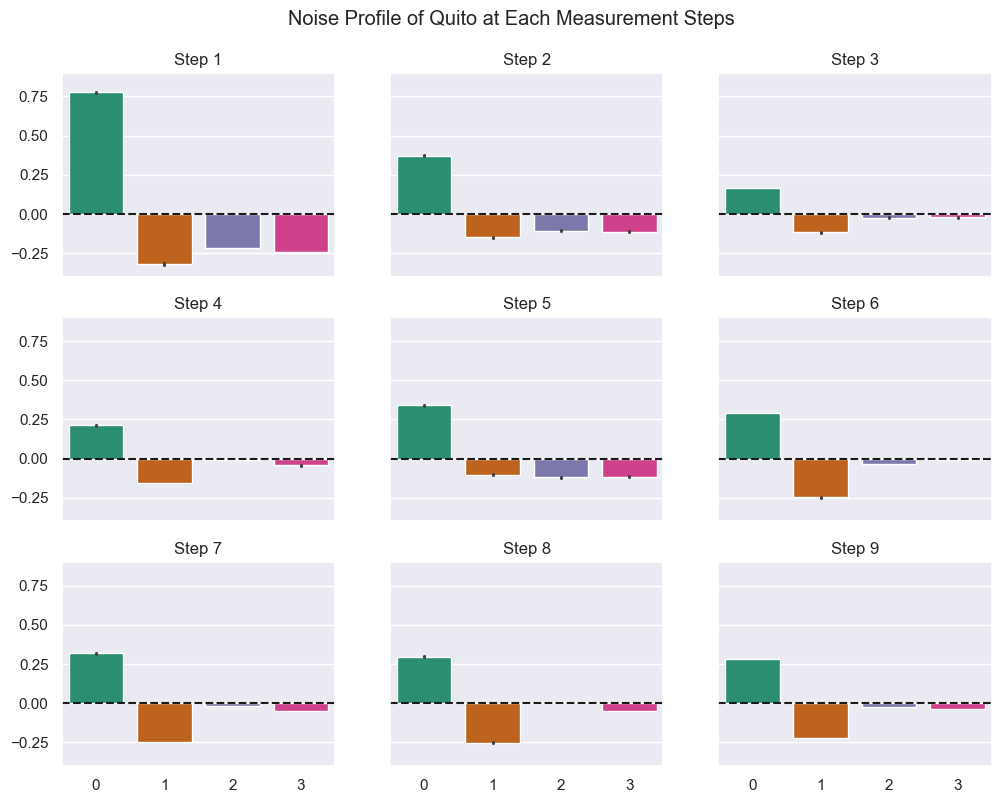

In [43]:
# For each measurement step in one machine.
fig, axes = plt.subplots(3, 3, figsize=(4*3, 3*3), sharex='col', sharey='row')

machine = 3
for step, ax in enumerate(axes.flatten()):
    # Data.
    xs, _, _, ys, _, _ = load_dataset(dataset_path, steps=[step], test_size=.0, val_size=.0, as_torch=False)
    xs_noise = xs - y_true
    
    # Plot.
    sns.barplot(xs_noise[ys == i], ax=ax, palette='Dark2')
    ax.axhline(0, color='k', linestyle='--')
    
    # Common scaling.
    ax.set_ylim(-.4, .9)
    
    # Titles.
    ax.set_title(f'Step {step+1}')
    
# Beautification.
fig.suptitle(f'Noise Profile of {machine_names[machine]} at Each Measurement Steps', y=.95)

plt.savefig(f'./figures/martina-{machine_names[machine].lower()}-noise-by-step.pdf', bbox_inches='tight')

## Noise Fingerprints as Entropy

Another interpretation is the difference between the obtained and true measurement distributions as quantified by entropy. This loses us the ability to consider noise fingerprints as higher-dimensional objects, which probably makes learning from them very difficult. Nevertheless, a scalar quantification of the 'noise fingerprint' may be useful for something else? 

Some ways to measure similarity of dissimilarity between probability distributions...
- **Kullback-Leibler (KL) Divergence**: $D_\text{KL}(P\ \|\ Q)=\sum_iP(i)\log\bigg(\frac{P(i)}{Q(i)}\bigg)$.
- **Jensen-Shannon (JS) Divergence**: $D_\text{JS}(P\ \|\ Q)=\frac{1}{2}D_\text{KL}(P\ \|\ M)+\frac{1}{2}D_\text{KL}(Q\ \|\ M)$, with $M=\frac{1}{2}(P+Q)$.

In [69]:
def kl_divergence(P : np.array, Q : np.array, eps : float = 1e-9):
    return max(sum([p * log((p / (q + eps)) + eps) for p, q in zip(P, Q)]), 0)

def js_divergence(P : np.array, Q : np.array, eps : float = 1e-9):
    M = .5 * (P + Q)
    return .5 * kl_divergence(P, M, eps) + .5 * kl_divergence(Q, M, eps)

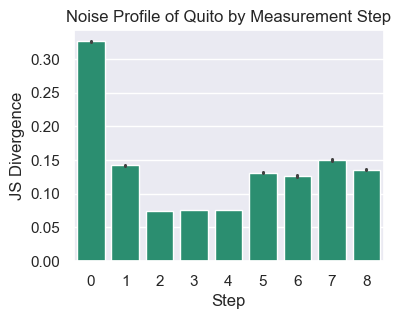

In [102]:
# For each measurement step for one machine.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

machine = 3
frames = []
for step in range(9):
    # Get data.
    xs, _, _, ys, _, _ = load_dataset(dataset_path, steps=[step], test_size=.0, val_size=.0, as_torch=False)
    xs_machine = xs[ys == machine]
    
    # Compute similarity.
    step_df = pd.DataFrame({
        'KL Divergence' : map(lambda x : kl_divergence(x, y_true), xs_machine), 
        'JS Divergence' : map(lambda x : js_divergence(x, y_true), xs_machine), 
        'Step' : [step] * xs_machine.shape[0]
    })
    
    # Add to list of dataframes.
    frames.append(step_df)

# Join list of dataframes.
noise_df = pd.concat(frames)

# Colour palette.
def colors_from_values(values, palette_name, max):
    indices = np.round((np.array(values) / max) * 100).astype(np.int32) - 1
    indices[indices > 100] = 0
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot.
sns.barplot(data=noise_df, x='Step', y='JS Divergence', ax=ax, color=sns.color_palette('Dark2')[0])

# Beautification.
ax.set_title(f'Noise Profile of {machine_names[machine]} by Measurement Step')

plt.savefig(f'./figures/noise-as-js-{machine_names[machine].lower()}.pdf', bbox_inches='tight')